## Дерево решений

Задание
1. Построить геометрическую интерпретацию критерия Джини()
2. Применить дерево решений из sklearn для задачи Titanic на kaggle (заполнив пропуски).  
Применить кросс-валидацию для подбора параметров и выбрать лучшие(например с помощью **GridSearchCV** из sklearn).  
Написать отчет о результатах.

In [76]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

import random

%matplotlib inline

In [27]:
train = pd.read_csv('titanic/train.csv', sep=',')
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [28]:
test = pd.read_csv('titanic/test.csv', sep=',')
test_targets = pd.read_csv('titanic/gender_submission.csv', sep=',')
test = test.assign(Survived = test_targets.Survived)
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [29]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Survived       418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [6]:
print(f'train shape - {train.shape}')
print(f'test shape - {test.shape}')

train shape - (891, 12)
test shape - (418, 12)


## Бейзлайн Титаника 

In [35]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

pipeline = Pipeline(steps = [('imputer', SimpleImputer()),('scaler',StandardScaler()),
                             ('tree',DecisionTreeClassifier())])
grid = {
    'tree__criterion' : ['gini', 'entropy'],
    'tree__max_depth' : [2,5],  
}
gridsearch = GridSearchCV(pipeline, grid, cv = 3)     
gridsearch.fit(np.array(train.loc[:,features]), np.array(train.Survived))
gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                        max_depth=5, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],


In [10]:
gridsearch.best_score_

0.7104377104377104

In [11]:
accuracy_score(y_pred = gridsearch.predict(np.array(test[features])), y_true = test.Survived)

0.6746411483253588

## 1. Геометрическая интерпретация критерия Джини 

**Задание** Построить график кривой Лоренца (https://habr.com/ru/company/ods/blog/350440/ - абзац с машиным обучением) 
            для дерева решений с разделением по критерию Джини, используя бейзлайн.

**Пример**

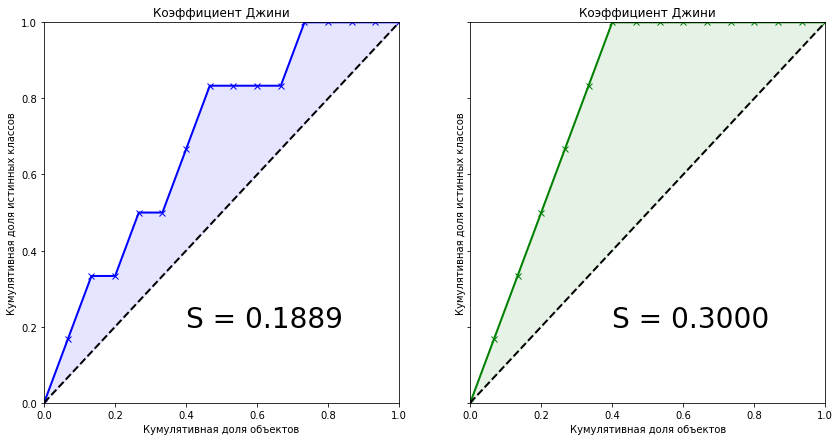

In [70]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predict = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

## 2. Контест Титаник

Побейте безлайн с помощью дерева решений(почерпнуть идеи можно из  
https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem,  
но модель в этом задание ограничивается деревом решений), выполните следующие пункты.  
Выберите наиболее сильную модель. Напишите отчет о результатах.


- Придумайте, как нужно использовать дополнительные признаки.
- Примените One-hot-encoding для категориальных признаков.
- Заполнить пропуски
- Применить кроссвалидацию
- отобрать параметры, например с помощью, GridSearchCV

In [33]:
#Copy
X_train=train[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
y_train=train['Survived']
X_test=test[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
#Age
X_train_age = np.random.randint(X_train["Age"].mean() - X_train["Age"].std(), 
                                X_train["Age"].mean() + X_train["Age"].std(),
                                size = X_train["Age"].isnull().sum())
X_test_age = np.random.randint(X_test["Age"].mean() - X_test["Age"].std(), 
                               X_test["Age"].mean() + X_test["Age"].std(),
                               size = X_test["Age"].isnull().sum())
X_train["Age"][np.isnan(X_train["Age"])] = X_train_age
X_test["Age"][np.isnan(X_test["Age"])] = X_test_age
X_train['Age'] = X_train['Age'].astype(int)
X_test['Age'] = X_test['Age'].astype(int)

# Embarked 
X_train["Embarked"].fillna('S', inplace=True)
X_test["Embarked"].fillna('S', inplace=True)

# Fare (всего одно значение, но все же)
X_test["Fare"].fillna(X_test["Fare"].median(), inplace=True)

#new features
X_train['isMale'] = X_train.Sex.replace({'male': 1, 'female':0})
X_train['hasCabin']=(~X_train['Cabin'].isnull()).astype(int)
X_train=pd.get_dummies(X_train, columns=['Pclass', 'Embarked'])

X_test['isMale'] = X_test.Sex.replace({'male': 1, 'female':0})
X_test['hasCabin']=(~X_test['Cabin'].isnull()).astype(int)
X_test=pd.get_dummies(X_test, columns=['Pclass', 'Embarked'])


X_train.drop(['PassengerId','Name','Sex','Ticket','Cabin'],axis=1,inplace=True)
X_test.drop(['PassengerId','Name','Sex','Ticket','Cabin'],axis=1,inplace=True)

X_train.head()

,Age,SibSp,Parch,Fare,isMale,hasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22,1,0,7.2500,1,0,0,0,1,0,0,1
1,38,1,0,71.2833,0,1,1,0,0,1,0,0
2,26,0,0,7.9250,0,0,0,0,1,0,0,1
3,35,1,0,53.1000,0,1,1,0,0,0,0,1
4,35,0,0,8.0500,1,0,0,0,1,0,0,1


In [34]:
X_test.head()

,Age,SibSp,Parch,Fare,isMale,hasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,34,0,0,7.8292,1,0,0,0,1,0,1,0
1,47,1,0,7.0000,0,0,0,0,1,0,0,1
2,62,0,0,9.6875,1,0,0,1,0,0,1,0
3,27,0,0,8.6625,1,0,0,0,1,0,0,1
4,22,1,1,12.2875,0,0,0,0,1,0,0,1


In [54]:
pipeline = Pipeline(steps = [('scaler',StandardScaler()),('tree',DecisionTreeClassifier(random_state=42))])
grid = {'tree__criterion' : ['gini', 'entropy'],'tree__max_depth' : range(1,10),'tree__max_features':range(2,12)}
gridsearch = GridSearchCV(pipeline, grid, cv = 5)     
gridsearch.fit(X_train,y_train)
gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                        max_depth=9, max_features=10,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=42,
                                        splitter='best'))],
         verbose=False)

In [55]:
gridsearch.best_score_

0.8204264870931538

In [56]:
results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values('mean_test_score',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__criterion,param_tree__max_depth,param_tree__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
178,0.004686,0.000081,0.001217,0.000024,entropy,9,10,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.810056,0.782123,0.842697,0.808989,0.858757,0.820426,0.027082,1
174,0.004623,0.000265,0.001312,0.000106,entropy,9,6,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.787709,0.804469,0.837079,0.797753,0.864407,0.818182,0.028346,2
131,0.003970,0.000091,0.001226,0.000046,entropy,5,3,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.798883,0.821229,0.831461,0.786517,0.841808,0.815937,0.020447,3
84,0.004376,0.000208,0.001321,0.000087,gini,9,6,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.765363,0.798883,0.853933,0.808989,0.853107,0.815937,0.033835,3
77,0.004386,0.000116,0.001220,0.000030,gini,8,9,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.826816,0.776536,0.808989,0.808989,0.847458,0.813692,0.023394,5


В целом, в сравнении с моделями SVM, LogisticRegression (https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem) одиночное дерево справляет с той же score. Лучше себя показывает RandomForest. <br>
По сравнению с исследованием по ссылке выше, добавление дополнительных фич, таких как число членов семьи, не сильно улучшает качество моделей.<br>
Так как данные достаточно разнородные одиночное дерево справляется хуже, чем могли бы случайный лес и ансамбли моделей.

## 3. Кривая Лоренца

Найдите лучшую модель с использованием Джини и постройте для нее кривую Лоренца,  
сравните с кривой для бейзлайновой модели

In [57]:
treeBL = DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                        max_depth=5, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best')     
treeBL.fit(X_train,y_train)
predictBL=treeBL.predict_proba(X_train)

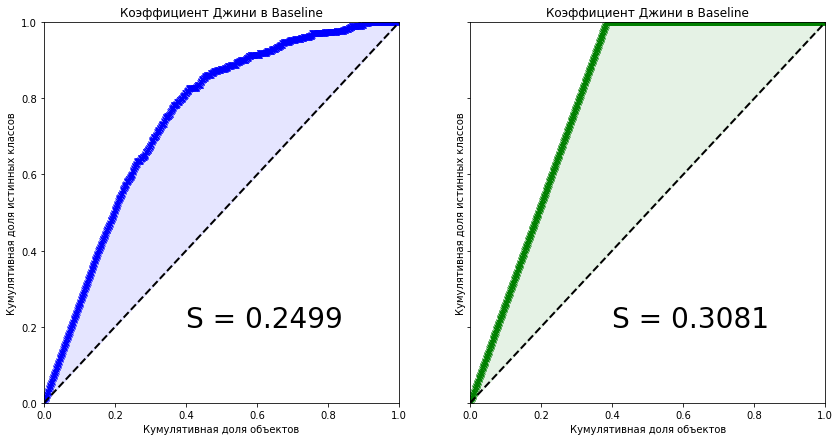

In [79]:
actual = y_train
predict = predictBL.T[1]

random.seed(1)

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=random.choices(x_values,k=50))[0] - 0.5
S_actual = quad(f2, 0, 1, points=random.choices(x_values,k=50))[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини в Baseline', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

In [80]:
pipeline = Pipeline(steps = [('scaler',StandardScaler()),('tree',DecisionTreeClassifier(random_state=42))])
grid = {'tree__criterion' : ['gini'],'tree__max_depth' : range(1,10),'tree__max_features':range(2,12)}
gridsearch = GridSearchCV(pipeline, grid, cv = 5)     
gridsearch.fit(X_train,y_train)
gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=9, max_features=6,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=42,
                                        splitter='best'))],
         verbose=False)

In [82]:
treeTM = DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=9, max_features=6,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=42,
                                        splitter='best')     
treeTM.fit(X_train,y_train)
predictTM=treeTM.predict_proba(X_train)

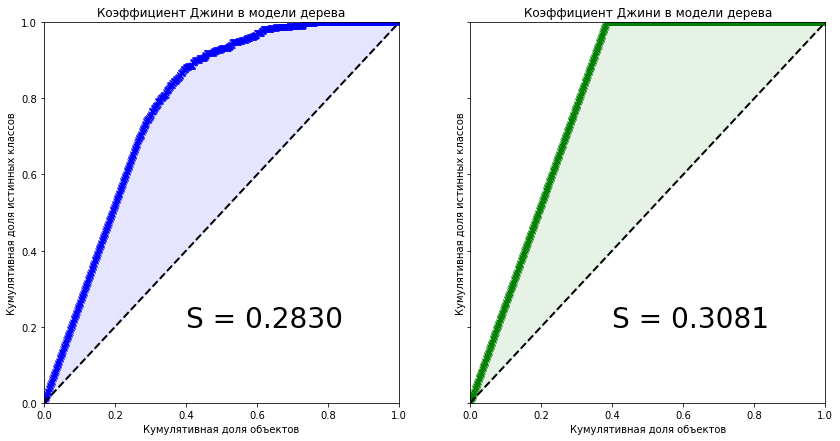

In [84]:
actual = y_train
predict = predictTM.T[1]

random.seed(1)

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=random.choices(x_values,k=50))[0] - 0.5
S_actual = quad(f2, 0, 1, points=random.choices(x_values,k=50))[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини в модели дерева', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

Коэффициент Джинни для построенной модели (0,2830) больше, чем в Baseline (0,2499).